# Avaliação de hiperparâmetros para agrupamento particional (KMeans) e hierárquico

#### Imports

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [32]:
# Read the data
df_vagas = pd.read_excel('data/vagas-pr-100.xlsx', index_col=0)
df_vagas.head()

,cod_ocupacao,salario,tipo_contratacao,qtd_experiencia,escolaridade
0,514120,600,3,2,1
1,783215,812,3,3,1
2,142205,0,3,6,6
3,513205,1200,3,6,2
4,763215,1656,3,6,0


In [33]:
df_vagas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   cod_ocupacao      101 non-null    int64
 1   salario           101 non-null    int64
 2   tipo_contratacao  101 non-null    int64
 3   qtd_experiencia   101 non-null    int64
 4   escolaridade      101 non-null    int64
dtypes: int64(5)
memory usage: 4.7 KB


#### Método

In [ ]:
"""
A classe BestModel armazena os melhores hiperparâmetros, baseado na validação dos índices 
Silhueta,  GAP e DBI (davies-bouldin) realizada sob a base de dados disponibilizada (ex. vagas-pr.csv)

Há uma matriz para cada um dos índices acima mencionados. 

Estas matrizes armazenam os valores dos índices obtidos alternando-se o nº de clusters entre [MINCLUTERS, MAXCLUSTERS]. 

O melhor resultado é armazenado em BestModel.
"""

In [34]:
class BestModel:
    """
    Classe para armazenar os melhores hiperparâmetros
    """
    def __init__(self, algo, metric, linkage, index, type):
        self.algorithm = algo
        self.metric = metric
        self.linkage = linkage
        self.index = index
        self.type = type
        self.k = 0 # number of clusters
    
    def setIndex(self, metric, linkage, index, k):
        self.index = metric
        self.linkage = linkage
        self.index = index
        self.k = k
        
    def show(self):
        print("".join("=" for i in range(100)))
        print("Algorithm: ", self.algorithm, "\nTipo de índice:", self.type, "\nMétrica:", self.metric, "\nLinkage:", self.linkage, "\nÍndice:", self.index, "\nNúmero de clusters:", self.k)
        print("".join("=" for i in range(100)))

#### Matrizes que guardam os resultados da clusterização por índice escolhido (silhueta, GAP e DBI) - KMeans

In [35]:
# matrix de resultados para o índice de silhueta
# Mede o grau de similaridade entre objetos do mesmo grupo e na distância entre objetos de cluters distintos.
# Resultados no intervalo [-1, 1], sendo 1 o melhor valor.
matrixSilhueta = [] 

# matrix de resultados para o índice GAP
# Mede a dispersão intracluster (entre clusters distintos) em relação à sua esperança sob uma distribuição de referência nula
matrixGAP = []

# matrix de resultados para o índice DBI (davies-bouldin)
# Verifica se os clusters estã bem separados e bem compactos, quanto menor melhor (min)
matrixDBI = []

##### Avaliar hiperparâmetros - KMeans

In [ ]:
# Métricas avaliadas
metric = ['euclidean', 'manhattan', 'cosine']

bestModelKMeans = BestModel('Agrupamento Particional - KMeans', metric[0], 0, -1, 'Índice de Silhueta')
bestModelKMeans_DBI = BestModel('Agrupamento Particional - K-Means', metric[0], 0, 1000, 'DBI: Davies-Bouldin')

# Número mínimo de clusters
MINCLUSTERS = 2

# Número máximo de clusters
MAXCLUSTERS = len(df_vagas) - 1

for j in range(len(metric)):
    silhouette_avg = []
    gap_index = []
    db_index_line = []
    
    for i in range(MINCLUSTERS, MAXCLUSTERS):
        kmeans = KMeans(n_clusters=i, random_state=123456)
        clustering = kmeans.fit_predict(df_vagas)
        index = silhouette_score(df_vagas, clustering, metric=metric[j])
        silhouette_avg.append(index)
        
        # Armazena o melhor resultado para o índice Silhueta (quanto maior melhor)
        if bestModelKMeans.index < index:
            bestModelKMeans.setIndex(metric[j], 0, index, i)
            
        # Cálculo do índice GAP
        var_intertia = kmeans.inertia_
        gap = np.log(np.mean(var_intertia)) - np.log(var_intertia)
        gap_index.append(gap)
        
        # Cálculo do índice DBI - Índice de Davies-Bouldin
        db_index = davies_bouldin_score(df_vagas, clustering)
        db_index_line.append(db_index)
        
        # Armazena o melhor resultado para o índice DBI (quanto menor melhor)
        if bestModelKMeans_DBI.index > index:
            bestModelKMeans_DBI.setIndex(metric[j], 0, index, i)
            
    matrixSilhueta.append(silhouette_avg)
    matrixGAP.append(gap_index)
    matrixDBI.append(db_index_line)

#### Gráfico do índice de Silhueta - KMeans

Text(0, 0.5, 'Coef. Silhouette')

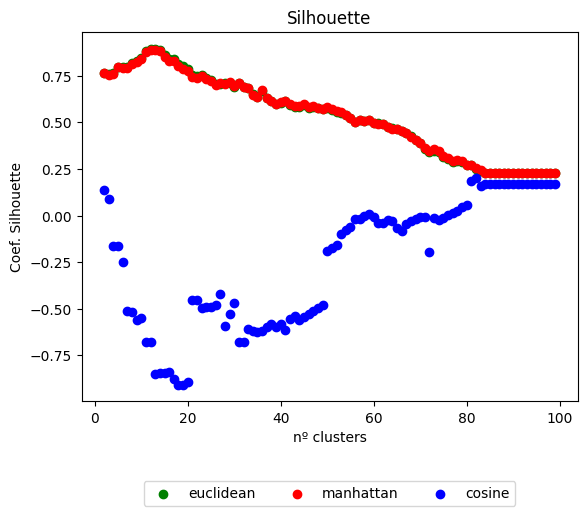

In [37]:
color_matrix = ['green', 'red', 'blue']

x = list(range(MINCLUSTERS, MAXCLUSTERS, 1))

for i in range(len(metric)):
    plt.scatter(x = x, y = matrixSilhueta[i], color = color_matrix[i], label = metric[i])

plt.legend(bbox_to_anchor=(0., -0.3, 1., .102), loc = "center", ncol = i + 1)
plt.title('Silhouette')
plt.xlabel('nº clusters')
plt.ylabel('Coef. Silhouette')


#### Gráfico dos valores encontrados usando o método GAP - KMeans

Text(0, 0.5, 'Índice GAP')

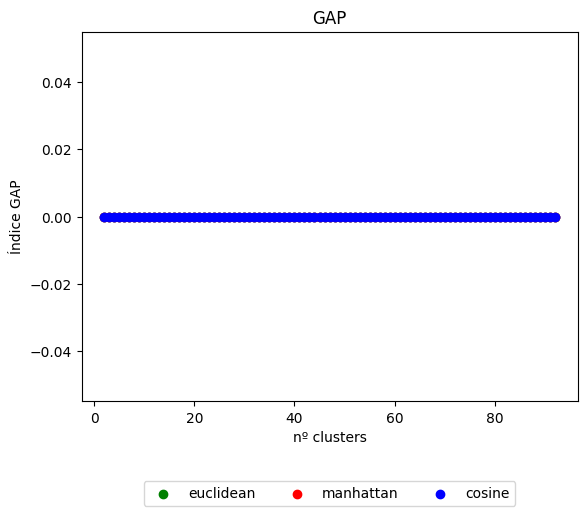

In [38]:
x = list(range(MINCLUSTERS, MAXCLUSTERS, 1))

for i in range(len(metric)):
    plt.scatter(x = x, y = matrixGAP[i], color = color_matrix[i], label=metric[i])
    
plt.legend(bbox_to_anchor=(0., -0.3, 1., .102), loc="center", ncol = i + 1)
plt.title('GAP')
plt.xlabel('nº clusters')
plt.ylabel('Índice GAP')

#### Gráfico dos valores encontrados usando o índice DBI - KMeans

Text(0, 0.5, 'Índice DBI')

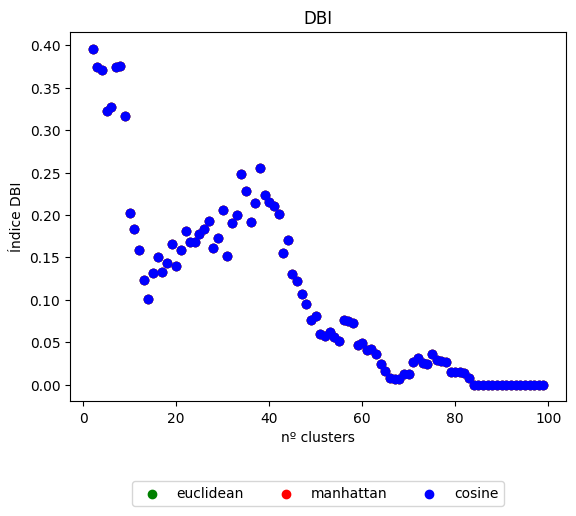

In [39]:
x = list(range(MINCLUSTERS, MAXCLUSTERS, 1))

for i in range(len(metric)):
    plt.scatter(x = x, y = matrixDBI[i], color = color_matrix[i], label=metric[i])
    
plt.legend(bbox_to_anchor=(0., -0.3, 1., .102), loc="center", ncol = i + 1)
plt.title('DBI')
plt.xlabel('nº clusters')
plt.ylabel('Índice DBI')

#### Matrizes que guardam os resultados da clusterização por índice escolhido (silhueta e DBI) - Agrupamento Hierárquico

In [11]:
matrixSilhueta = []
matrixDBI = []

##### Avaliar hiperparâmetros - Agrupamento Hierárquico (*Aglomerative Clustering*)

In [40]:
# Métricas e linkage avaliado
metric = ['euclidean', 'manhattan', 'cosine']
linkage_type = ['average', 'complete', 'single']

bestModelAgrupHierarquico = BestModel('Agrupamento Hierárquico', metric[0], 0, -1, 'Índice de Silhueta')
bestModelAgrupHierarquico_DBI = BestModel('Agrupamento Hierárquico', metric[0], 0, 1000, 'DBI: Davies-Bouldin')

for i in range(3): # affinity
    linkage = []
    DBIndex = []
    
    for j in range(3): # linkage
        silhouette_avg = []
        db_index_line = []
    
        for k in range(MINCLUSTERS, MAXCLUSTERS):
            clustering = AgglomerativeClustering(n_clusters = k, affinity = metric[i], linkage = linkage_type[j])
            predict = clustering.fit_predict(df_vagas)
            
            # Cálculo do índice Silhueta
            index = silhouette_score(df_vagas, predict, metric=metric[i])
            silhouette_avg.append(index)
            
            if (bestModelAgrupHierarquico.index < index):
                bestModelAgrupHierarquico.setIndex(metric[i], linkage_type[j], index, k)
                
            # Cálculo do índice DBI - Índice de Davies-Bouldin
            db_index = davies_bouldin_score(df_vagas, predict)
            db_index_line.append(db_index)
            
            if (bestModelAgrupHierarquico_DBI.index > index):
                bestModelAgrupHierarquico_DBI.setIndex(metric[i], linkage_type[j], index, k)
                
        linkage.append(silhouette_avg)
        DBIndex.append(db_index_line)
        
    matrixSilhueta.append(linkage)
    matrixDBI.append(DBIndex)

#### Gráfico do índice de Silhueta - Agrupamento Hierárquico

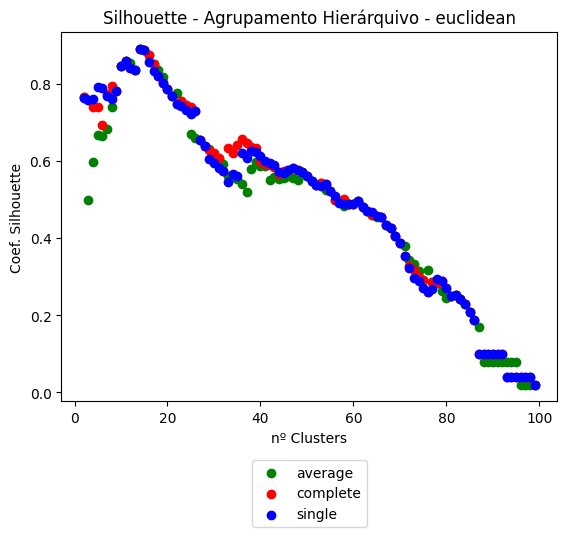

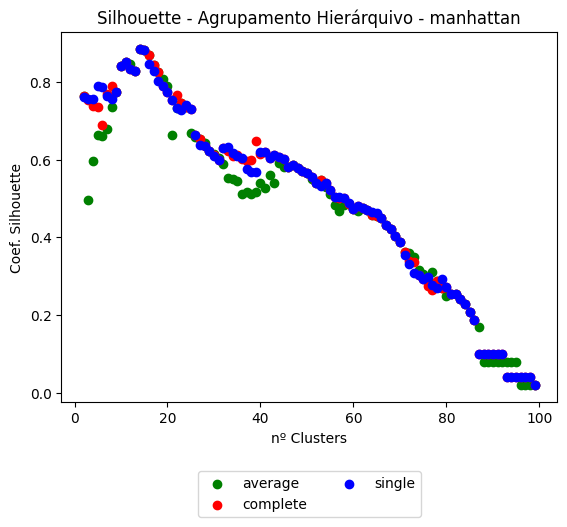

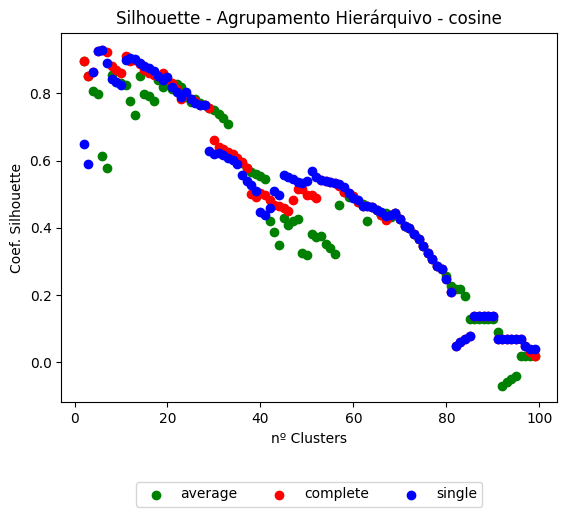

In [16]:
xlist = list(range(2, len(matrixSilhueta[0][0]) + 2, 1))

for i in range(3): # affinity
  for j in range(3): # linkage
    plt.scatter(x = xlist, y = matrixSilhueta[i][j], color = color_matrix[j], label = linkage_type[j])
  plt.legend(bbox_to_anchor=(0., -0.3, 1., .102), loc = "center", ncol = i + 1)
  plt.title("Silhouette - Agrupamento Hierárquivo - " + metric[i])
  plt.xlabel("nº Clusters")
  plt.ylabel("Coef. Silhouette")
  plt.show()

#### Gráfico do índice DBI - Agrupamento Hierárquico

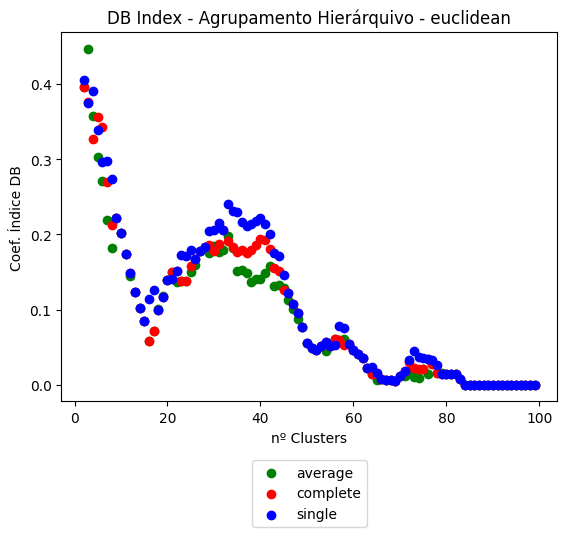

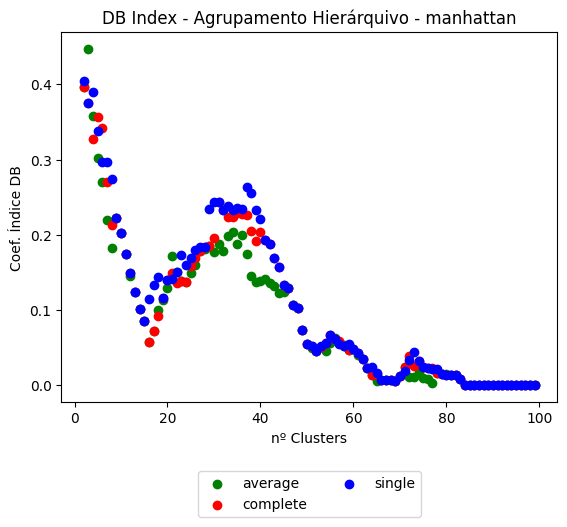

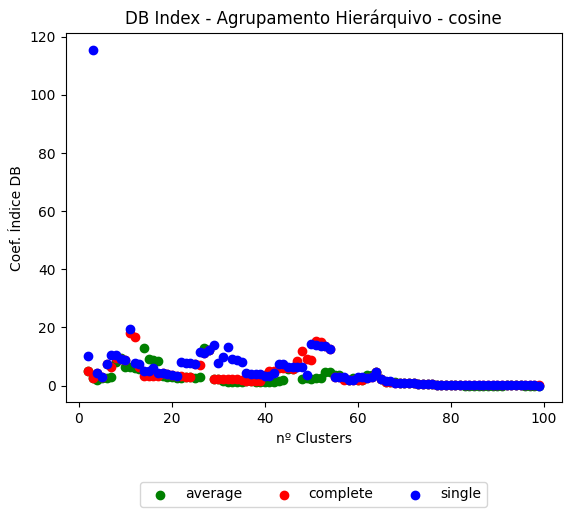

In [17]:
xlist = list(range(2, len(matrixDBI[0][0]) + 2, 1))

for i in range(3): # affinity
  for j in range(3): # linkage
    plt.scatter(x = xlist, y = matrixDBI[i][j], color = color_matrix[j], label = linkage_type[j])
    
  plt.legend(bbox_to_anchor=(0., -0.3, 1., .102),loc="center", ncol=i+1)
  plt.title("DB Index - Agrupamento Hierárquivo - " + metric[i])
  plt.xlabel("nº Clusters")
  plt.ylabel("Coef. Índice DB")
  plt.show()

**Validação dos Resultados**
- Foram utilizados o índice Silhoutte para os algoritmos implementados.
- Foram alcançados os resultados abaixo:

In [21]:
# Imprime os melhores hiperparâmetros para o método KMeans
bestModelKMeans.show()
bestModelAgrupHierarquico_DBI.show()

Algorithm:  Agrupamento Particional - KMeans 
Tipo de índice: Índice de Silhueta 
Métrica: euclidean 
Linkage: 0 
Índice: 0.8955104794259672 
Número de clusters: 13
Algorithm:  Agrupamento Hierárquico 
Tipo de índice: DBI: Davies-Bouldin 
Métrica: euclidean 
Linkage: single 
Índice: -0.06930693069306931 
Número de clusters: 92


In [20]:
# Imprime os melhores hiperparâmetros para o método Agrupamento Hierárquico
bestModelAgrupHierarquico.show()
bestModelAgrupHierarquico_DBI.show()

Algorithm:  Agrupamento Hierárquico 
Tipo de índice: Índice de Silhueta 
Métrica: euclidean 
Linkage: average 
Índice: 0.9298248939362634 
Número de clusters: 6
Algorithm:  Agrupamento Hierárquico 
Tipo de índice: DBI: Davies-Bouldin 
Métrica: euclidean 
Linkage: single 
Índice: -0.06930693069306931 
Número de clusters: 92
